# K-Nearest Neighbor Classifier Analysis

**Project Summary:**
The primary goal of the analysis is to design an algorithm using the k-nearest neighbors (KNN) classifier and refine its performance with quantitative metrics suited to improve predictive accuracy. Implementing Select K Best as a feature selection method identifies the most suitable predictive features to include in the model. These selected features build the model and are optimized through hyperparameter analysis using GridSearhCV. The grid search results aid in the design of the final, optimized machine learning model.
<br><br>

**Research Question:**
Can the k-nearest neighbor classifier be used to accurately predict
patient Readmissions?
<br><br>
## **Table of Contents**
1. [Importing Dataset](#import-data)

2. [Preprocessing](#pre)

3. [Model Preperation](#model-prep)

4. [Model Refining](#model-tune)

5. [KNN Classifier Model](#model)

6. [Results](#results)

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="import-data"></a>

# Import Dataset
- Rename itemized features to corresponding names in data dictionary
- View first few rows of data
- Look for duplicate records
- Search for any null values

In [ ]:
# Upload CSV file and create backup

data = pd.read_csv(r'/content/drive/MyDrive/data_files/medical_clean_d207_8_9.csv')
data_backup = data

# Rename Item columns to represent their corresponding survey category
data.rename(columns = {'Item1':'Timely_admission',
                       'Item2': 'Timely_treatment',
                       'Item3':'Timely_visits',
                       'Item4':'Reliability',
                       'Item5':'Options',
                       'Item6':'Hours_of_treatment',
                       'Item7':'Courteous_staff',
                       'Item8':'Listening_doctor'}, inplace = True)


# View first 3 rows of dataframe
data.head(3)


,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_of_treatment,Courteous_staff,Listening_doctor
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.40342,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.99812,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.19246,2,4,4,4,3,4,3,3


In [ ]:
# Explore data before preping for predictive modeling
# Confirm no duplicate entries for data by checking for unique patient ids

data['Customer_id'].duplicated().value_counts()

False    10000
Name: Customer_id, dtype: int64

In [ ]:
# Search for null values
# Cannot have missing data in KNN analysis

data.isnull().sum()

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

In [ ]:
# Explore data types, identify target variable and explanatory variables
# Search df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

<a name="pre"></a>
# Preprocessing
- View summary stastics of numeric and categorical features
- Re-express target feature to numeric
- Identify statistical outliers
  - Z-scores for normal distributions
  - Inter-quartile method for positive/negative skewed data
- Tedium of outlier removal is intentional as required for assessment

In [ ]:
# Task 1 dataframe
t1 = data.copy(deep = True)

# Re-express response variable ReAdmis yes/no to 0/1
t1['ReAdmis'].replace(['Yes', 'No'], [1, 0], inplace = True)

In [ ]:
# View summary statistics before selecting variables for model
t1.describe()

# Numeric data to be cleaned and explored
# Features to address --- Initial Days, Total Charge, Additional Charges, Doctor Visits, Vitamin D Levels, Vitamin D Supplements, Full Meals Eaten, Children, Age, Population, Zip
# Note: Lat/Lng not to be cleaned due to nature of coordinate data being precise

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,ReAdmis,VitD_levels,...,TotalCharge,Additional_charges,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_of_treatment,Courteous_staff,Listening_doctor
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,50159.323900,38.751099,-91.243080,9965.253800,2.097200,53.511700,40490.495160,0.366900,17.964262,...,5312.172769,12934.528587,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,2886.89568,27469.588208,5.403085,15.205998,14824.758614,2.163659,20.638538,28521.153293,0.481983,2.017231,...,2180.393838,6542.601544,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,1.00000,610.000000,17.967190,-174.209700,0.000000,0.000000,18.000000,154.080000,0.000000,9.806483,...,1938.312067,3125.703000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2500.75000,27592.000000,35.255120,-97.352982,694.750000,0.000000,36.000000,19598.775000,0.000000,16.626439,...,3179.374015,7986.487755,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,5000.50000,50207.000000,39.419355,-88.397230,2769.000000,1.000000,53.000000,33768.420000,0.000000,17.951122,...,5213.952000,11573.977735,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,7500.25000,72411.750000,42.044175,-80.438050,13945.000000,3.000000,71.000000,54296.402500,1.000000,19.347963,...,7459.699750,15626.490000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,10000.00000,99929.000000,70.560990,-65.290170,122814.000000,10.000000,89.000000,207249.100000,1.000000,26.394449,...,9180.728000,30566.070000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [ ]:
# View summary statistics of categorical data
t1.describe(include = 'object')

,Customer_id,Interaction,UID,City,State,County,Area,TimeZone,Job,Marital,...,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,10000,10000,6072,52,1607,3,26,639,5,...,2,2,2,2,2,2,2,2,2,4
top,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Houston,TX,Jefferson,Rural,America/New_York,Outdoor activities/education manager,Widowed,...,Yes,No,No,No,No,No,No,No,No,Blood Work
freq,1,1,1,36,553,118,3369,3889,29,2045,...,7094,6426,7262,6628,5886,6785,6059,5865,7107,5265


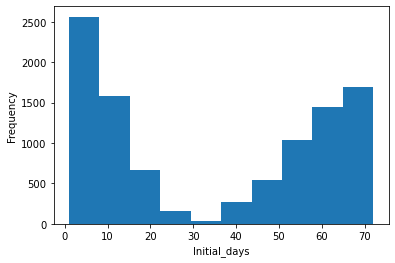


 ----------------------------------------------------- 

count    10000.000000
mean        34.455299
std         26.309341
min          1.001981
25%          7.896215
50%         35.836244
75%         61.161020
max         71.981490
Name: Initial_days, dtype: float64

 ----------------------------------------------------- 



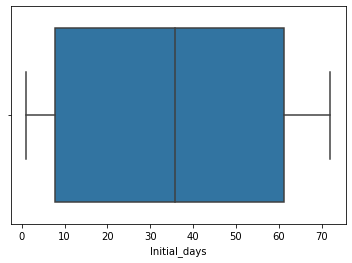

In [ ]:
# Explore Data for cleaning
# Start Treatment for Outliers

# Initial Days
# Detect and treat - Initial_days

# Plot histogram of initial days
plt.hist(t1['Initial_days'])
plt.xlabel("Initial_days")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of initial days
print(t1['Initial_days'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of initial days
sns.boxplot(x='Initial_days', data = t1);

In [ ]:
# Look for  outliers using z-scores
days_z = stats.zscore(t1['Initial_days'])

print((days_z > 3).value_counts())
print('\n ---------- \n')
print((days_z < -3).value_counts())

False    10000
Name: Initial_days, dtype: int64

 ---------- 

False    10000
Name: Initial_days, dtype: int64


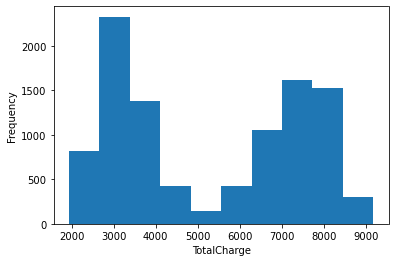


 ----------------------------------------------------- 

count    10000.000000
mean      5312.172769
std       2180.393838
min       1938.312067
25%       3179.374015
50%       5213.952000
75%       7459.699750
max       9180.728000
Name: TotalCharge, dtype: float64

 ----------------------------------------------------- 



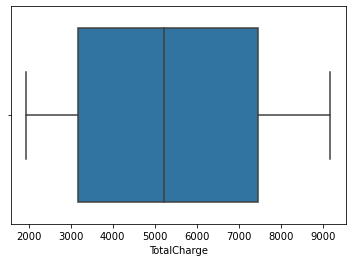

In [ ]:
# Total Charge
# Detect and treat - Total Charge
# Plot histogram of Total Charge


# Plot histogram of total charge
plt.hist(t1['TotalCharge'])
plt.xlabel("TotalCharge")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Total Charge
print(t1['TotalCharge'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Total Charge
sns.boxplot(x='TotalCharge', data = t1);

In [ ]:
# Look for outliers using z-scores
totalcharge_z = stats.zscore(t1['TotalCharge'])

print((totalcharge_z > 3).value_counts())
print('\n ---------- \n')
print((totalcharge_z < -3).value_counts())

False    10000
Name: TotalCharge, dtype: int64

 ---------- 

False    10000
Name: TotalCharge, dtype: int64


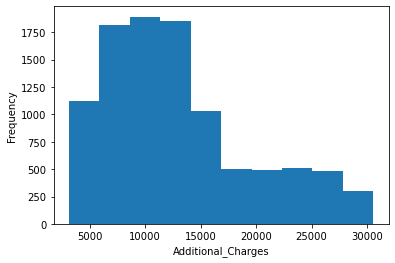


 ----------------------------------------------------- 

count    10000.000000
mean     12934.528587
std       6542.601544
min       3125.703000
25%       7986.487755
50%      11573.977735
75%      15626.490000
max      30566.070000
Name: Additional_charges, dtype: float64

 ----------------------------------------------------- 



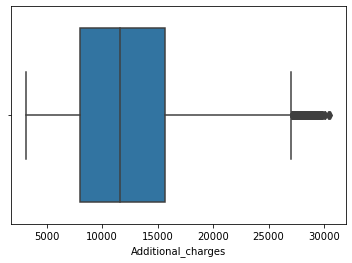

In [ ]:
# Additional_charges
# Detect and treat - Additional Charges
# Plot histogram of Additional Charges


# Plot histogram of Additional Charges
plt.hist(t1['Additional_charges'])
plt.xlabel("Additional_Charges")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Additional Charges
print(t1['Additional_charges'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Additional Charges
sns.boxplot(x='Additional_charges', data = t1);



In [ ]:
# Treat Outliers - Additional Charges
# Identify q1, q3, iqr, upper and lower fences
q1_add  = t1['Additional_charges'].quantile(0.25)
q3_add  = t1['Additional_charges'].quantile(0.75)
iqr_add  = q3_add - q1_add

upper_add = q3_add + 1.5*iqr_add
lower_add = q1_add - 1.5*iqr_add

# Subset of Additional Charges outlers
Additional_charges_outliers = pd.DataFrame(t1[ (t1['Additional_charges'] >= (upper_add)) | (t1['Additional_charges'] <= (lower_add))])

# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_1 = pd.DataFrame(t1[ (t1['Additional_charges'] < (upper_add)) & (t1['Additional_charges'] > (lower_add))])
t1_clean_1.reset_index(drop = True)

# Confirm removal of outliers
print("Original Dataframe: " + str(t1.shape[0]))
print("Number of Additional Charges Outilers: " +str(Additional_charges_outliers.shape[0]))
print("Confirm removal of Additional Charges Outliers: " + str(t1_clean_1.shape[0]))

Original Dataframe: 10000
Number of Additional Charges Outilers: 424
Confirm removal of Additional Charges Outliers: 9576


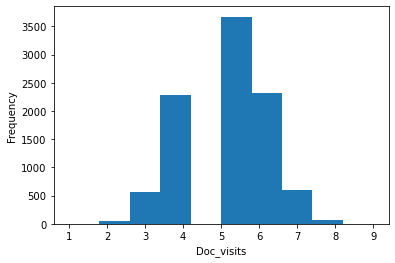


 ----------------------------------------------------- 

count    9576.000000
mean        5.010547
std         1.045389
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: Doc_visits, dtype: float64

 ----------------------------------------------------- 



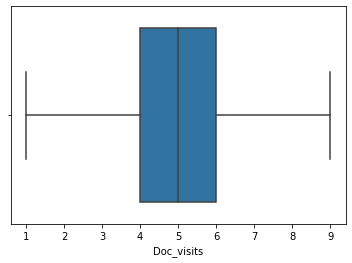

In [ ]:
# Doc_visits
# Detect and treat - Doc Visits

# Plot histogram of Doc Visits
plt.hist(t1_clean_1['Doc_visits'])
plt.xlabel("Doc_visits")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Doc Visits
print(t1_clean_1['Doc_visits'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Doc Visits
sns.boxplot(x='Doc_visits', data = t1_clean_1);

In [ ]:
# Treat outliers - Doctor Vists
# Search for outliers on normal distribution using z-scores
t1_clean_1['Doc_visits_z'] = stats.zscore(t1_clean_1['Doc_visits'])


# Remove outliers --  -3 > df > 3
t1_clean_2 = pd.DataFrame(t1_clean_1[ (t1_clean_1['Doc_visits_z'] < 3) & (t1_clean_1['Doc_visits_z'] > -3)])
t1_clean_2.reset_index(drop = True)


# Subset of Doctor Visits outliers
Doc_visits_outliers = pd.DataFrame(t1_clean_1[ (t1_clean_1['Doc_visits_z'] > 3) | (t1_clean_1['Doc_visits_z'] < -3)])


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_1.shape[0]))
print("Number of Doctor Visit Outliers: " + str(Doc_visits_outliers.shape[0]))
print("Confirm removal of Doctor Visit Outilers: " + str(t1_clean_2.shape[0]))

Current dataframe: 9576
Number of Doctor Visit Outliers: 7
Confirm removal of Doctor Visit Outilers: 9569


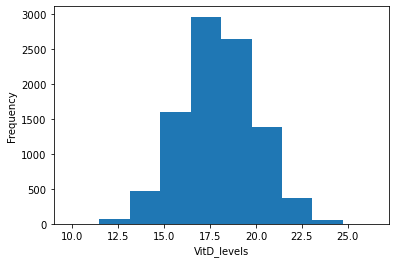


 ----------------------------------------------------- 

count    9569.000000
mean       17.963320
std         2.016458
min         9.806483
25%        16.629982
50%        17.946411
75%        19.341870
max        26.394449
Name: VitD_levels, dtype: float64

 ----------------------------------------------------- 



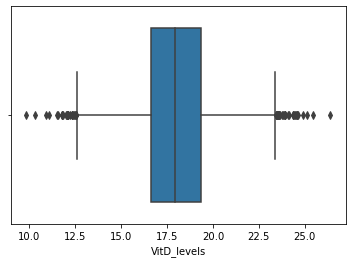

In [ ]:
# Vitamin D Levels
# Detect and treat - Vitamin D Levels

# Plot histogram of Vitamin D Levels
plt.hist(t1_clean_2['VitD_levels'])
plt.xlabel("VitD_levels")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Vitamin D Levels
print(t1_clean_2['VitD_levels'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Vitamin D Levels
sns.boxplot(x='VitD_levels', data = t1_clean_2);






In [ ]:
# Treat outliers - Vitamin D Levels
# Search for outliers on normal distribution using z-scores
t1_clean_2['VitD_levels_z'] = stats.zscore(t1_clean_2['VitD_levels'])


# Subset of Additional Charges outlers
VitD_levels_outliers = pd.DataFrame(t1_clean_2[ (t1_clean_2['VitD_levels_z'] > 3) | (t1_clean_2['VitD_levels_z'] < -3)])


# Remove outliers --  -3 > df > 3
t1_clean_3 = pd.DataFrame(t1_clean_2[ (t1_clean_2['VitD_levels_z'] < 3) & (t1_clean_2['VitD_levels_z'] > -3)])
t1_clean_3.reset_index(drop = True)


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_2.shape[0]))
print("Number of Vitamin D Level Outliers: " + str(VitD_levels_outliers.shape[0]))
print("Confirm removal of Vitamin D Level Outliers: " + str(t1_clean_3.shape[0]))


Current dataframe: 9569
Number of Vitamin D Level Outliers: 24
Confirm removal of Vitamin D Level Outliers: 9545


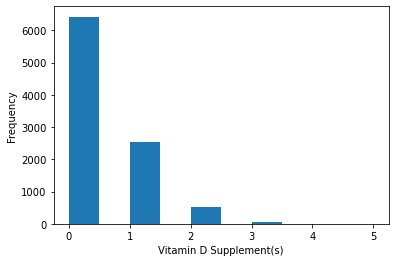


 ----------------------------------------------------- 

count    9545.000000
mean        0.395495
std         0.626831
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: vitD_supp, dtype: float64

 ----------------------------------------------------- 



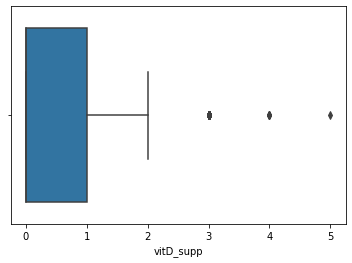

In [ ]:
# Vitamin D Supplement --- df = t1_clean_3
# Detect and treat - Vitamin D Supplement

# Plot histogram of Vitamin D Supplement
plt.hist(t1_clean_3['vitD_supp'])
plt.xlabel("Vitamin D Supplement(s)")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Vitamin D Supplement
print(t1_clean_3['vitD_supp'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Vitamin D Supplement
sns.boxplot(x='vitD_supp', data = t1_clean_3);



In [ ]:
# Treate Outliers - Vitamin D Supplement
# Identify q1, q3, iqr, upper and lower fences

q1_vitd_supp  = t1_clean_3['vitD_supp'].quantile(0.25)
q3_vitd_supp  = t1_clean_3['vitD_supp'].quantile(0.75)
iqr_vitd_supp  = q3_vitd_supp - q1_vitd_supp


upper_vitd_supp = q3_vitd_supp + 1.5*iqr_vitd_supp
lower_vitd_supp = q1_vitd_supp - 1.5*iqr_vitd_supp

# Subset of Vitamin D Supplement outliers
vitD_supp_outliers = pd.DataFrame(t1_clean_3[ (t1_clean_3['vitD_supp'] >= (upper_vitd_supp)) | (t1_clean_3['vitD_supp'] <= (lower_vitd_supp))])


# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_4 = t1_clean_3[ (t1_clean_3['vitD_supp'] < (upper_vitd_supp)) & (t1_clean_3['vitD_supp'] > (lower_vitd_supp))]
t1_clean_4.reset_index(drop = True)


# Confirm removal of outliers
print("Current dataframe: "+ str(t1_clean_3.shape[0]))
print("Number of Vitamin D Supplement Outlers: " + str(vitD_supp_outliers.shape[0]))
print("Confirm removal of Vitamin D Supplement Outliers: " + str(t1_clean_4.shape[0]))


Current dataframe: 9545
Number of Vitamin D Supplement Outlers: 68
Confirm removal of Vitamin D Supplement Outliers: 9477


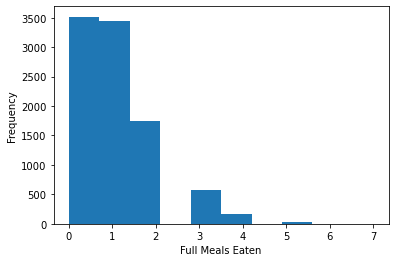


 ----------------------------------------------------- 

count    9477.000000
mean        1.001161
std         1.007412
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: Full_meals_eaten, dtype: float64

 ----------------------------------------------------- 



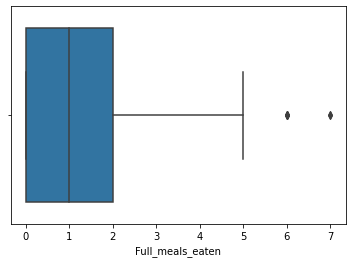

In [ ]:
# Full Meals Eaten --- t1_clean4 - current df
# Detect and treat - Full Meals Eaten


# Plot histogram of Full Meals Eaten
plt.hist(t1_clean_4['Full_meals_eaten'])
plt.xlabel("Full Meals Eaten")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Full Meals Eaten
print(t1_clean_4['Full_meals_eaten'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Full Meals Eaten
sns.boxplot(x='Full_meals_eaten', data = t1_clean_4);

In [ ]:
# Treat Outliers - Full Meals Eaten

# Identify q1, q3, iqr, upper and lower fences

q1_full  = t1_clean_4['Full_meals_eaten'].quantile(0.25)
q3_full  = t1_clean_4['Full_meals_eaten'].quantile(0.75)
iqr_full  = q3_full - q1_full


upper_full = q3_full + 1.5*iqr_full
lower_full = q1_full - 1.5*iqr_full

# Subset of Full Meals Eaten outliers
Full_meals_eaten_outliers = pd.DataFrame(t1_clean_4[ (t1_clean_4['Full_meals_eaten'] >= (upper_full)) | (t1_clean_4['Full_meals_eaten'] <= (lower_full))])


# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_5 = t1_clean_4[ (t1_clean_4['Full_meals_eaten'] < (upper_full)) & (t1_clean_4['Full_meals_eaten'] > (lower_full))]
t1_clean_5.reset_index(drop = True)

# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_4.shape[0]))
print("Number of Full Meals Eaten Outliers: " + str(Full_meals_eaten_outliers.shape[0]))
print("Confirm removal of Full Meals Eaten Outliers: " + str(t1_clean_5.shape[0]))


Current dataframe: 9477
Number of Full Meals Eaten Outliers: 31
Confirm removal of Full Meals Eaten Outliers: 9446


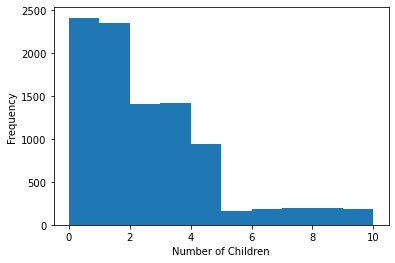


 ----------------------------------------------------- 

count    9446.000000
mean        2.094114
std         2.155455
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        10.000000
Name: Children, dtype: float64

 ----------------------------------------------------- 



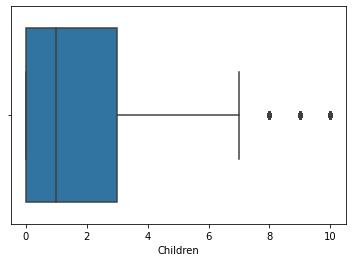

In [ ]:
# Children --- t1_clean_5
# Detect and treat - Children

# Plot histogram of Children
plt.hist(t1_clean_5['Children'])
plt.xlabel("Number of Children")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Children
print(t1_clean_5['Children'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Children
sns.boxplot(x='Children', data = t1_clean_5);

In [ ]:
# Treat Outliers - Children

# Identify q1, q3, iqr, upper and lower fences

q1_children  = t1_clean_5['Children'].quantile(0.25)
q3_children  = t1_clean_5['Children'].quantile(0.75)
iqr_children  = q3_children - q1_children


upper_children = q3_children + 1.5*iqr_children
lower_children = q1_children - 1.5*iqr_children

# Subset of Children outliers
Children_outliers = pd.DataFrame(t1_clean_5[ (t1_clean_5['Children'] >= (upper_children)) | (t1_clean_5['Children'] <= (lower_children))])

# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_6 = t1_clean_5[ (t1_clean_5['Children'] < (upper_children)) & (t1_clean_5['Children'] > (lower_children))]
t1_clean_6.reset_index(drop = True)

# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_5.shape[0]))
print("Number of Children Outliers: " + str(Children_outliers.shape[0]))
print("Confirm removal of Children Outliers: " + str(t1_clean_6.shape[0]))

Current dataframe: 9446
Number of Children Outliers: 379
Confirm removal of Children Outliers: 9067


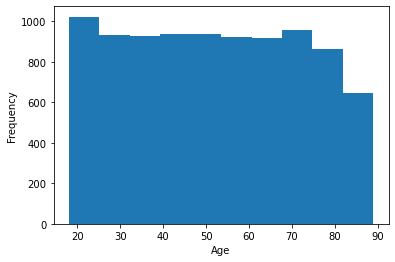


 ----------------------------------------------------- 

count    9067.000000
mean       51.991839
std        19.945440
min        18.000000
25%        35.000000
50%        52.000000
75%        69.000000
max        89.000000
Name: Age, dtype: float64

 ----------------------------------------------------- 



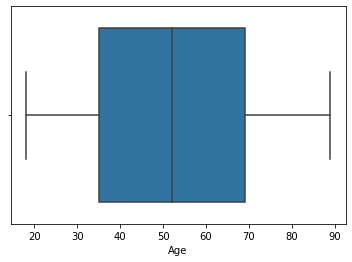

In [ ]:
# Age  ---  t1_clean_6
# Detect and treat - Age

# Plot histogram of Age
plt.hist(t1_clean_6['Age'])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Age
print(t1_clean_6['Age'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Age
sns.boxplot(x='Age', data = t1_clean_6);

In [ ]:
# Treat outliers - Age
# Search for outliers on normal distribution using z-scores

# if copy error shows use below
#pd.options.mode.chained_assignment = None  # default='warn'

t1_clean_6['Age_z'] = stats.zscore(t1_clean_6['Age'])


# Remove outliers --  -3 > df > 3
t1_clean_7 = pd.DataFrame(t1_clean_6[ (t1_clean_6['Age_z'] < 3) & (t1_clean_6['Age_z'] > -3)])
t1_clean_7.reset_index(drop = True)


# Subset of Age outlers
Age_outliers = pd.DataFrame(t1_clean_6[ (t1_clean_6['Age_z'] > 3) | (t1_clean_6['Age_z'] < -3)])


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_6.shape[0]))
print("Number of Age Outliers: " + str(Age_outliers.shape[0]))
print("Confirm removal of Age Outlers: " + str(t1_clean_7.shape[0]))


Current dataframe: 9067
Number of Age Outliers: 0
Confirm removal of Age Outlers: 9067


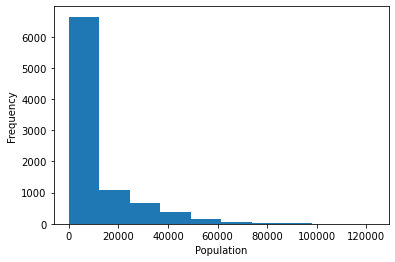


 ----------------------------------------------------- 

count      9067.000000
mean       9956.987758
std       14790.992979
min           0.000000
25%         690.000000
50%        2793.000000
75%       13924.500000
max      122814.000000
Name: Population, dtype: float64

 ----------------------------------------------------- 



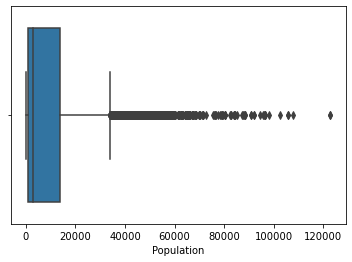

In [ ]:
# Population --- t1_clean_7
# Detect and treat - Population

# Plot histogram of Population
plt.hist(t1_clean_7['Population'])
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Population
print(t1_clean_7['Population'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Population
sns.boxplot(x='Population', data = t1_clean_7);

In [ ]:
# Treate Outliers - Population

# Identify q1, q3, iqr, upper and lower fences

q1_population  = t1_clean_7['Population'].quantile(0.25)
q3_population  = t1_clean_7['Population'].quantile(0.75)
iqr_population  = q3_population - q1_population


upper_population = q3_population + 1.5*iqr_population
lower_population = q1_population - 1.5*iqr_population

# Subset of Population outliers
Population_outliers = pd.DataFrame(t1_clean_7[ (t1_clean_7['Population'] >= (upper_population)) | (t1_clean_7['Population'] <= (lower_population))])

# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_8 = t1_clean_7[ (t1_clean_7['Population'] <= (upper_population)) & (t1_clean_7['Population'] >= (lower_population))]
t1_clean_8.reset_index(drop = True)


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_7.shape[0]))
print("Number of Population Outliers: " + str(Population_outliers.shape[0]))
print("Confirm removal of Population Outliers: " + str(t1_clean_8.shape[0]))

Current dataframe: 9067
Number of Population Outliers: 775
Confirm removal of Population Outliers: 8292


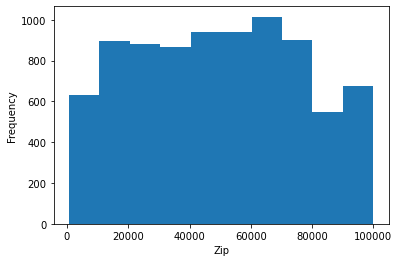

count     8292.000000
mean     49433.173058
std      26921.450834
min        610.000000
25%      27089.500000
50%      49884.000000
75%      70753.500000
max      99929.000000
Name: Zip, dtype: float64


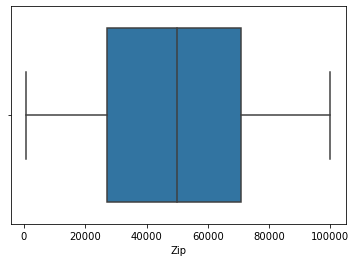

In [ ]:
# Income --- t1_clean_8
# Detect and treat - Zip

# Plot histogram of Zip
plt.hist(t1_clean_8['Zip'])
plt.xlabel("Zip")
plt.ylabel("Frequency")
plt.show()

# Summary statistics of Income
print(t1_clean_8['Zip'].describe())

# Plot boxplot of Income
sns.boxplot(x='Zip', data = t1_clean_8);

In [ ]:
# Treat outliers - Zip
# Search for outliers on normal distribution using z-scores
t1_clean_8['Zip_z'] = stats.zscore(t1_clean_8['Zip'])


# Remove outliers --  -3 > df > 3
t1_clean_9 = pd.DataFrame(t1_clean_8[ (t1_clean_8['Zip_z'] < 3) & (t1_clean_8['Zip_z'] > -3)])
t1_clean_9.reset_index(drop = True)


# Subset of Zip outlers
Zip_outliers = pd.DataFrame(t1_clean_8[ (t1_clean_8['Zip_z'] > 3) | (t1_clean_8['Zip_z'] < -3)])


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_8.shape[0]))
print("Number of Zip Outliers: " + str(Zip_outliers.shape[0]))
print("Confirm removal of Zip Outliers: " + str(t1_clean_9.shape[0]))


Current dataframe: 8292
Number of Zip Outliers: 0
Confirm removal of Zip Outliers: 8292


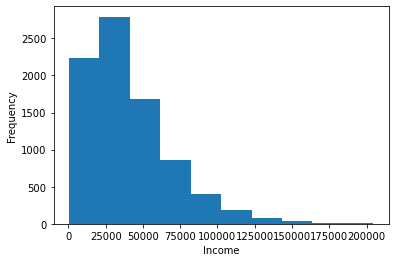


 ----------------------------------------------------- 

count      8292.000000
mean      40425.658243
std       28351.932085
min         300.790000
25%       19659.330000
50%       33733.965000
75%       54062.097500
max      204542.410000
Name: Income, dtype: float64

 ----------------------------------------------------- 



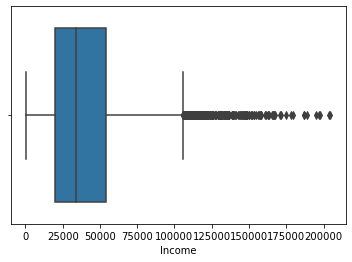

In [ ]:
# Income --- t1_clean_9
# Detect and treat - Income

# Plot histogram of Income
plt.hist(t1_clean_9['Income'])
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

print('\n ----------------------------------------------------- \n')

# Summary statistics of Income
print(t1_clean_9['Income'].describe())

print('\n ----------------------------------------------------- \n')

# Plot boxplot of Income
sns.boxplot(x='Income', data = t1_clean_9);

In [ ]:
# Treate Outliers - Income

# Identify q1, q3, iqr, upper and lower fences

q1_income  = t1_clean_9['Income'].quantile(0.25)
q3_income  = t1_clean_9['Income'].quantile(0.75)
iqr_income  = q3_income - q1_income


upper_income = q3_income + 1.5*iqr_income
lower_income = q1_income - 1.5*iqr_income

# Subset of Income outliers
Income_outliers = pd.DataFrame(t1_clean_9[ (t1_clean_9['Income'] >= (upper_income)) | (t1_clean_9['Income'] <= (lower_income))])

# create new dataframe with removal of outliers
# filter dataframe to only include samples within range of fences
t1_clean_10 = t1_clean_9[ (t1_clean_9['Income'] <= (upper_income)) & (t1_clean_9['Income'] >= (lower_income))]
t1_clean_10.reset_index(drop = True)


# Confirm removal of outliers
print("Current dataframe: " + str(t1_clean_9.shape[0]))
print("Number of Income Outliers: " + str(Income_outliers.shape[0]))
print("Confirm removal of Income Outliers: " + str(t1_clean_10.shape[0]))

Current dataframe: 8292
Number of Income Outliers: 277
Confirm removal of Income Outliers: 8015


<a name="model-prep"></a>
# Model Preperation
- Drop z-score columns
- Drop features not related to task
- Encode binary categorical variables to numeric
- Encode remaining categorical variables with dummies
- Calculate correlation coefficients and plot heatmap

In [ ]:
# Drop z score columns
t1_clean_10.drop(columns = ['Doc_visits_z', 'Age_z', 'Zip_z', 'VitD_levels_z'], axis = 1, inplace = True)



In [ ]:
# Define model dataframe from cleaned data
df = t1_clean_10.copy(deep = True)
print(df.shape)

# Backup and testing df
df_backup = df.copy(deep = True)



(8015, 50)


In [ ]:
# Drop features not relevent to task

df.drop(columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'TimeZone', 'Job', 'Marital'], axis = 1, inplace = True)

df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8015 entries, 0 to 9998
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip                 8015 non-null   int64  
 1   Lat                 8015 non-null   float64
 2   Lng                 8015 non-null   float64
 3   Population          8015 non-null   int64  
 4   Area                8015 non-null   object 
 5   Children            8015 non-null   int64  
 6   Age                 8015 non-null   int64  
 7   Income              8015 non-null   float64
 8   Gender              8015 non-null   object 
 9   ReAdmis             8015 non-null   int64  
 10  VitD_levels         8015 non-null   float64
 11  Doc_visits          8015 non-null   int64  
 12  Full_meals_eaten    8015 non-null   int64  
 13  vitD_supp           8015 non-null   int64  
 14  Soft_drink          8015 non-null   object 
 15  Initial_admin       8015 non-null   object 
 16  HighBl

In [ ]:
# Summary statisics of cleaned data
df.describe()

,Zip,Lat,Lng,Population,Children,Age,Income,ReAdmis,VitD_levels,Doc_visits,...,TotalCharge,Additional_charges,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_of_treatment,Courteous_staff,Listening_doctor
count,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,...,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000
mean,49328.613225,38.978898,-90.741039,6374.598628,1.813974,52.079975,37398.143970,0.367810,17.949930,5.006737,...,5306.959100,12220.012176,3.513288,3.498815,3.509420,3.514910,3.490206,3.521647,3.498316,3.519401
std,26932.488283,5.302044,14.727676,8420.426774,1.697325,19.899710,23288.592847,0.482239,1.981921,1.035533,...,2181.889071,5808.887839,1.034852,1.036141,1.030665,1.039522,1.031751,1.040723,1.017057,1.040887
min,610.000000,17.967190,-174.209700,0.000000,0.000000,18.000000,300.790000,0.000000,12.038470,2.000000,...,1938.312067,3125.703000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,26697.500000,35.659095,-96.874170,609.500000,0.000000,35.000000,19142.740000,0.000000,16.618482,4.000000,...,3176.195615,7811.016000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,49819.000000,39.630330,-88.275680,2217.000000,1.000000,52.000000,32612.150000,0.000000,17.926359,5.000000,...,5164.982000,11256.620000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000
75%,70664.000000,42.197510,-80.411315,9024.000000,3.000000,69.000000,51417.775000,1.000000,19.321476,6.000000,...,7458.887500,14788.967060,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,99929.000000,70.560990,-65.290170,33769.000000,7.000000,89.000000,105596.200000,1.000000,23.941426,8.000000,...,9169.248000,27038.530000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [ ]:
# Summary statistics of categorical data
# Look for binary variables to encode
df.describe(include = 'object')

,Area,Gender,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services
count,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015,8015
unique,3,3,2,3,2,2,3,2,2,2,2,2,2,2,2,2,4
top,Rural,Female,No,Emergency Admission,No,No,Medium,Yes,No,No,No,No,No,No,No,No,Blood Work
freq,2715,4053,5964,4042,4970,6434,3665,5681,5119,5826,5306,4727,5429,4864,4723,5703,4219


In [ ]:
# Encoding binary variables
# Binary features: Soft Drink, High Blood, Stroke, Overweight, Arthritis, Diabetes, Hyperlipidemia, Back Pain, Anxiety, Allergic Rhinitis, Reflux Esophagitis, and Asthma
binary_cols = ['Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma' ]
binary_values = {'Yes': 1, 'No': 0}

for col in binary_cols:
  df[col] = df[col].replace(binary_values)

# Confirm binary encoding

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8015 entries, 0 to 9998
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip                 8015 non-null   int64  
 1   Lat                 8015 non-null   float64
 2   Lng                 8015 non-null   float64
 3   Population          8015 non-null   int64  
 4   Area                8015 non-null   object 
 5   Children            8015 non-null   int64  
 6   Age                 8015 non-null   int64  
 7   Income              8015 non-null   float64
 8   Gender              8015 non-null   object 
 9   ReAdmis             8015 non-null   int64  
 10  VitD_levels         8015 non-null   float64
 11  Doc_visits          8015 non-null   int64  
 12  Full_meals_eaten    8015 non-null   int64  
 13  vitD_supp           8015 non-null   int64  
 14  Soft_drink          8015 non-null   int64  
 15  Initial_admin       8015 non-null   object 
 16  HighBl

In [ ]:
# View summary stats of remaining categorical types before one-hot encoding
# Area, Gender, Initial Admin, Complication Risk, and Services to be encoded

df.describe(include = 'object')

,Area,Gender,Initial_admin,Complication_risk,Services
count,8015,8015,8015,8015,8015
unique,3,3,3,3,4
top,Rural,Female,Emergency Admission,Medium,Blood Work
freq,2715,4053,4042,3665,4219


In [ ]:
# Loop to create dummy variables
for col in df:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns = [col], prefix = col)

# Confirm addition of dummies
df.head()

,Zip,Lat,Lng,Population,Children,Age,Income,ReAdmis,VitD_levels,Doc_visits,...,Initial_admin_Elective Admission,Initial_admin_Emergency Admission,Initial_admin_Observation Admission,Complication_risk_High,Complication_risk_Low,Complication_risk_Medium,Services_Blood Work,Services_CT Scan,Services_Intravenous,Services_MRI
0,35621,34.34960,-86.72508,2951,1,53,86575.93,0,19.141466,6,...,0,1,0,0,0,1,1,0,0,0
1,32446,30.84513,-85.22907,11303,3,51,46805.99,0,18.940352,4,...,0,1,0,1,0,0,0,0,1,0
2,57110,43.54321,-96.63772,17125,3,53,14370.14,0,18.057507,4,...,1,0,0,0,0,1,1,0,0,0
3,56072,43.89744,-93.51479,2162,0,78,39741.49,0,16.576858,4,...,1,0,0,0,0,1,1,0,0,0
4,23181,37.59894,-76.88958,5287,1,22,1209.56,0,17.439069,5,...,1,0,0,0,1,0,0,1,0,0


In [ ]:
# Confrim all numeric data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8015 entries, 0 to 9998
Data columns (total 51 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Zip                                  8015 non-null   int64  
 1   Lat                                  8015 non-null   float64
 2   Lng                                  8015 non-null   float64
 3   Population                           8015 non-null   int64  
 4   Children                             8015 non-null   int64  
 5   Age                                  8015 non-null   int64  
 6   Income                               8015 non-null   float64
 7   ReAdmis                              8015 non-null   int64  
 8   VitD_levels                          8015 non-null   float64
 9   Doc_visits                           8015 non-null   int64  
 10  Full_meals_eaten                     8015 non-null   int64  
 11  vitD_supp                     

In [ ]:
# Calculate correlation values relative to target variable - Readmissions
# Dataframe correlations relative to Readmissions
df_corr = df.corr()['ReAdmis']

In [ ]:
# Sort correlations
correlations = df_corr.sort_values(ascending = False)
print(correlations)

ReAdmis                                1.000000
Initial_days                           0.851399
TotalCharge                            0.844674
Services_CT Scan                       0.032910
vitD_supp                              0.024866
Initial_admin_Emergency Admission      0.023448
Population                             0.016652
Children                               0.016374
VitD_levels                            0.015261
BackPain                               0.015065
Gender_Male                            0.013012
Age                                    0.012902
Soft_drink                             0.012820
Services_MRI                           0.011999
Complication_risk_Medium               0.011933
Arthritis                              0.007983
Hyperlipidemia                         0.007440
Area_Urban                             0.007022
Options                                0.006489
Anxiety                                0.004894
Zip                                    0

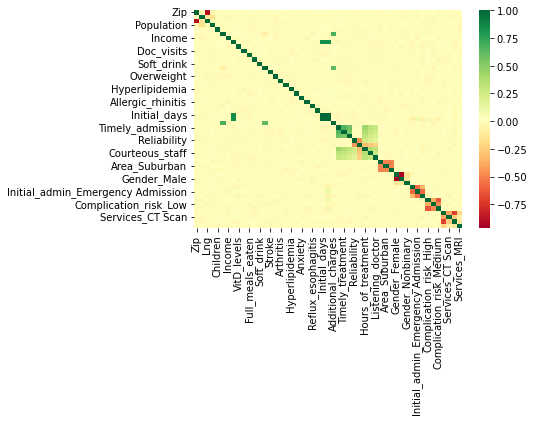

In [ ]:
# Heatmap of correlations

sns.heatmap(df.corr(), cmap = 'RdYlGn');

In [ ]:
# Compare percentages of readmissions before and after cleaning dataframe
pct_readmis_full = data['ReAdmis'].value_counts() / (data['ReAdmis']).shape[0]
pct_readmis_clean = df['ReAdmis'].value_counts() / (df['ReAdmis']).shape[0]

print("Percentages of Readmissions from Original Dataset: " + '\n' + str(pct_readmis_full))
print('\n ---------------------------- \n')
print("Percentages of Readmissions from Cleaned Data: "  + '\n' + str(pct_readmis_clean))

Percentages of Readmissions from Original Dataset: 
No     0.6331
Yes    0.3669
Name: ReAdmis, dtype: float64

 ---------------------------- 

Percentages of Readmissions from Cleaned Data: 
0    0.63219
1    0.36781
Name: ReAdmis, dtype: float64


<a name="model-tune"></a>
# Model Refining
- Use Select K Best to identify features relative to target feature, Readmissions
  - Retain features that measure below alpha or 0.05
- Create new dataframe with best features
- Use standard scaler to standardize data
- Use 70/30 train/test split for model training and validation
- Hyperparameter tuning with GridSearchCV
- Plot model complexity and corroborate optimized number of neighbors

In [ ]:
# Feature selection for knn analysis
# SELECT K BEST

# assign values for x and y
x_best = df.drop(['ReAdmis'], axis = 1)
y_best = df['ReAdmis']

print(x_best.shape)
print(y_best.shape)

(8015, 50)
(8015,)


In [ ]:
# Make SelectKBest model
features = x_best.columns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

best = SelectKBest(score_func = f_classif, k = 'all')

x_best_model = best.fit_transform(x_best, y_best)


In [ ]:
# Finding p-values
p_values = pd.DataFrame({'Feature': x_best.columns, 'p_value': best.pvalues_}).sort_values('p_value')

print(p_values)

                                Feature   p_value
24                          TotalCharge  0.000000
23                         Initial_days  0.000000
47                     Services_CT Scan  0.003212
10                            vitD_supp  0.026003
41    Initial_admin_Emergency Admission  0.035801
48                 Services_Intravenous  0.040015
40     Initial_admin_Elective Admission  0.062559
26                     Timely_admission  0.072723
3                            Population  0.136052
4                              Children  0.142715
28                        Timely_visits  0.145491
7                           VitD_levels  0.171910
18                             BackPain  0.177468
22                               Asthma  0.177487
31                   Hours_of_treatment  0.222468
33                     Listening_doctor  0.227822
1                                   Lat  0.228562
37                        Gender_Female  0.233179
38                          Gender_Male  0.244096


In [ ]:
# View features that measure below alpha (0.05)
p_values[p_values['p_value'] < 0.05]

,Feature,p_value
24,TotalCharge,0.000000
23,Initial_days,0.000000
47,Services_CT Scan,0.003212
10,vitD_supp,0.026003
41,Initial_admin_Emergency Admission,0.035801
48,Services_Intravenous,0.040015


In [ ]:
# Print features to keep
features_to_keep = p_values['Feature'][p_values['p_value'] < 0.05]

print(features_to_keep)

24                          TotalCharge
23                         Initial_days
47                     Services_CT Scan
10                            vitD_supp
41    Initial_admin_Emergency Admission
48                 Services_Intravenous
Name: Feature, dtype: object


In [ ]:
# Filter df and include only features found significant using SelectKBest

t1 = df [['ReAdmis', 'TotalCharge', 'Initial_days', 'Services_CT Scan', 'vitD_supp', 'Initial_admin_Emergency Admission', 'Services_Intravenous']]

# View new df
t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8015 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ReAdmis                            8015 non-null   int64  
 1   TotalCharge                        8015 non-null   float64
 2   Initial_days                       8015 non-null   float64
 3   Services_CT Scan                   8015 non-null   uint8  
 4   vitD_supp                          8015 non-null   int64  
 5   Initial_admin_Emergency Admission  8015 non-null   uint8  
 6   Services_Intravenous               8015 non-null   uint8  
dtypes: float64(2), int64(2), uint8(3)
memory usage: 336.6 KB


In [ ]:
# Import Standard Scaler to standardize data
from sklearn.preprocessing import StandardScaler

# Define standard scaler
scaler = StandardScaler()

# For PA dataframe of cleaned and standardize data
# Separate explanatory variables and use fit_transrorm
t1_x = t1.drop(['ReAdmis'], axis = 1)
t1_x_std = pd.DataFrame(scaler.fit_transform(t1_x), columns = t1_x.columns)

# Isolate response variable
t1_y = t1['ReAdmis']

# Prepare for concat
std_df = [t1_y, t1_x_std]

# Concat for pa submission
data_std = pd.concat(std_df, axis = 1)

data_std.head(3)

,ReAdmis,TotalCharge,Initial_days,Services_CT Scan,vitD_supp,Initial_admin_Emergency Admission,Services_Intravenous
0,0.0,-0.724306,-0.907278,-0.378207,-0.639219,0.991428,-0.67250
1,0.0,-0.510493,-0.734737,-0.378207,1.072554,0.991428,1.48699
2,0.0,-1.316705,-1.128036,-0.378207,-0.639219,-1.008646,-0.67250


In [ ]:
# Train/Test split Post Select K Best
# Import train test split
from sklearn.model_selection import train_test_split

# Define response and explanatory variables
X = t1.drop(['ReAdmis'], axis = 1)
y = t1['ReAdmis']

# Split response and explanatory variables into train and test sets
# Stratify to retain proportional response data representation
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 61, stratify=y)

# Print shape of train/test sets
print('Train Set')
print(x_train.shape)
print(y_train.shape)
print('\n ----- \n')
print('Test Set')
print(x_test.shape)
print(y_test.shape)

Train Set
(5610, 6)
(5610,)

 ----- 

Test Set
(2405, 6)
(2405,)


In [ ]:
# Files for Performance Assessment
# Standardize train and test data and put into data frames
x_train_std_pa = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test_std_pa = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

# Make copy of response variables for y train/test
y_train_pa = y_train.copy(deep = True)
y_test_pa = y_test.copy(deep = True)

# Prep df's for concat
train_df = [y_train_pa, x_train_std_pa]
test_df = [y_test_pa, x_test_std_pa]

# Combine train/test for corresponding df's
train_std = pd.concat(train_df, axis = 1)
test_std = pd.concat(test_df, axis = 1)

In [ ]:
# Standardize train/test data - using Standard Scaler

# Standardize data
# Train data uses method fit_transform()
x_train_std =  scaler.fit_transform(x_train)

# Test data standardized with transform() method - want to keep the scale from train data to use on test data, not include test data in the scaling
x_test_std = scaler.transform(x_test)

In [ ]:
# Employ GridSearchCV for hyperparameter tuning and KNN optimization
# Import KNN classification model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters, selecting upto 1% of train data for k-neighbor optimization, look for optimized weights, algorithm, and metric
params = {'n_neighbors': np.arange(1, 56), 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'metric': ('manhattan', 'euclidean', 'minkowski')}

In [ ]:
# K-nearest neighbors
# Define knn classifier --- NOTE: default values --- n_neighbors = '5', weights = 'uniform', metric = 'minkowski', algorithm = 'auto'
knn = KNeighborsClassifier()

# KNN GridSearchCV using 5-fold cross validation
knn_cv = GridSearchCV(knn, params, cv = 5)

# Fit model
grid_fit = knn_cv.fit(x_train_std, y_train)

# Print results
print("Best Parameters: " + str(grid_fit.best_params_))
print("Best Score: " + str(grid_fit.best_score_))

Best Parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
Best Score: 0.97825311942959


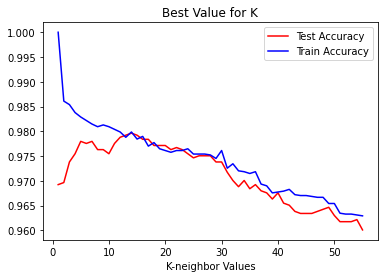

In [ ]:
# Model complexity of k neighbors
# (Geeks for Geeks, 2020)

neighbors = list(range(1, 56))
n_test =[]
n_train =[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train_std, y_train)
    z = knn.score(x_test_std, y_test)
    t = knn.score(x_train_std, y_train)
    n_test.append(z)
    n_train.append(t)

plt.plot(neighbors, n_test, color ='red', label ='Test Accuracy')
plt.plot(neighbors, n_train, color ='b', label ='Train Accuracy')
plt.xlabel('K-neighbor Values')
plt.title('Best Value for K')
plt.legend()
plt.show()

<a name="model"></a>
# Model
- Instantiate k-nearest neighbor classifier
- Set knn classifier parameters to optimized perfomance as found through GridSearchCV
- Fit model to train data
- Calculate model predictions
- Calculate accuracy scores based on test data set
- Compute confusion matrix and visualize

In [ ]:
# Classification model after finding best parameters
# Define best classifier based on GridSearchCV results
best_knn = KNeighborsClassifier(n_neighbors = 14, weights = 'distance', algorithm = 'auto', metric = 'manhattan')

# Fit best model
model = best_knn.fit(x_train_std, y_train)

# Best Predictions
predictions = model.predict(x_test_std)

In [ ]:
# Import accruacy_score
from sklearn.metrics import accuracy_score

# Calculate Accuracy score of test predictions
accuracy_score = accuracy_score(y_test, predictions)

print("Accuracy Score: %0.3f" % (accuracy_score*100) + "%")

Accuracy Score: 97.630%


<a name="results"></a>
# Results
- Compute confusion matrix and visualize
- Performance Calculations: Accruacy, Precision, Sensitivity/Recall, Specificity
- Classificaiton report
- Plot ROC curve
- Calculate ROC-AUC score

Confusion Matrix 

[[1497   23]
 [  34  851]]




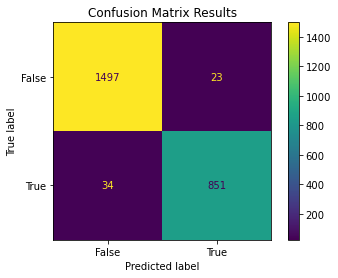

In [ ]:
# Assess metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Run confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Print results
# SOURCE https://www.w3schools.com/python/python_ml_confusion_matrix.asp
print("Confusion Matrix", '\n')
print(matrix)
print('\n')
matrix_visual = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
matrix_visual.plot()
plt.title("Confusion Matrix Results")
plt.show()

In [ ]:
# define true postive, true negative, false positive, false negative variables
tn = matrix[0,0]
fp = matrix[0,1]
fn = matrix[1,0]
tp = matrix[1,1]

print('True Negatives: ' + str(tn))
print('False Negatives: ' + str(fn))
print('True Positives: ' + str(tp))
print('False Positives: ' + str(fp))



True Negatives: 1497
False Negatives: 34
True Positives: 851
False Positives: 23


In [ ]:
# Performance Calculations - Accruacy, Precision, Sensitivity/Recall, Specificity
# Population total
population = tp + tn + fp + fn


# Accuracy calculation --- sum true pos + true neg / population
# How often is the model correct?
accuracy = (tp + tn) / population

# Precision calcualtion --- true pos / sum of true pos + false pos
# Of the positives predicted, what percentage is truly positive?
precision = tp / (tp+fp)


# Sensitivity/Recall calculation --- true positivies / sum of true pos + false neg
# Of all the positive cases, what percentage are predicted positive? / how good is model at predicting positive cases
sensitivity = tp / (tp + fn)

# Specificity calculation --- true negatives / sum of true neg + false pos
# How well the model is at prediciting negative results?
specificity = tn / (tn + fp)


print("Accuracy: %0.3f" % (accuracy))
print("Precision:  %0.3f" % (precision))
print("Sensitivity/Recall: %0.3f" % (sensitivity))
print("Specificty: %0.3f" % (specificity))


Accuracy: 0.976
Precision:  0.974
Sensitivity/Recall: 0.962
Specificty: 0.985


In [ ]:
# Assess metrics - Classification Report
from sklearn.metrics import classification_report


# Confusiton Matrix and Classification Report
class_report = classification_report(y_test, predictions)


print('\n')
print("Classification Report", '\n')
print(class_report)



Classification Report 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1520
           1       0.97      0.96      0.97       885

    accuracy                           0.98      2405
   macro avg       0.98      0.97      0.97      2405
weighted avg       0.98      0.98      0.98      2405



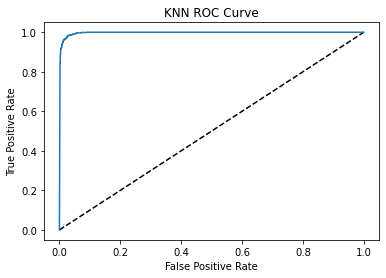

In [ ]:
# Continuing with python tutorial from wgu webinar / data camp
# Compare models
from sklearn.metrics import roc_curve

# Define prediction probability
prediction_prob = best_knn.predict_proba(x_test_std)[:, 1]

# Calculate ROC (false postive rate, true positive rate, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)


# Plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

In [ ]:
# Import ROC_AUC score
from sklearn.metrics import roc_auc_score

# Calculate ROC_AUC score using best parameters
roc_auc_score = roc_auc_score(y_test, prediction_prob)

# Print AUC score
print("ROC-AUC Score: %0.3f" % (roc_auc_score))

ROC-AUC Score: 0.997
